# 인공지능과 가위바위보하기 [프로젝트]

<br/>

**평가문항**
1. 이미지 분류기 모델이 성공적으로 만들어졌는가?
  - 학습과정이 정상적으로 수행되었으며, 학습 결과에 대한 그래프를 시각화(ex. train acc / train loss / val acc / val loss 등) 해 보았음
2. 오버피팅을 극복하기 위한 적절한 시도가 있었는가?
  - 오버피팅 극복을 위하여 데이터셋의 다양성, 정규화 등을 2가지 이상 시도해보았음
3. 분류모델의 test accuracy가 기준 이상 높게 나왔는가?
  - 85% 이상 도달하였음

## 1. 데이터 준비

In [186]:
from PIL import Image 
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1.1. 이미지 크기 통일 (28x28)

In [187]:
# 경로 안 jpg 이미지를 28x28 사이즈로 변경하는 함수
def resize_images(img_path, recursive=False):
    path = img_path
    if recursive:
        path += "/**/*.jpg"
    else:
        path += "/*.jpg"
    
    images=glob.glob(path, recursive=recursive)  
    
    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")

In [188]:
# 학습용 및 테스트용 이미지의 사이즈를 변경하는 함수
def resize_train_test_images(recursive=False):
    folder_names = ['scissor', 'rock', 'paper',
                    'test/scissor', 'test/rock', 'test/paper']
    
    for folder_name in folder_names:
        image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/" + folder_name
        resize_images(image_dir_path, recursive)
        print(folder_name, "이미지 resize 완료!")

In [189]:
# 학습용 및 테스트용 이미지 사이즈 변경
resize_train_test_images()

300  images to be resized.
300  images resized.
scissor 이미지 resize 완료!
300  images to be resized.
300  images resized.
rock 이미지 resize 완료!
300  images to be resized.
300  images resized.
paper 이미지 resize 완료!
100  images to be resized.
100  images resized.
test/scissor 이미지 resize 완료!
100  images to be resized.
100  images resized.
test/rock 이미지 resize 완료!
100  images to be resized.
100  images resized.
test/paper 이미지 resize 완료!


### 1.2. 이미지 데이터 불러오기

In [190]:
# 경로 안 이미지를 불러오는 함수
def load_data(img_path, number_of_data=300, recursive=False):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    
    path = img_path + "/scissor"
    if recursive:
        path += "/**/*.jpg"
    else:
        path += "/*.jpg"
    
    for file in glob.iglob(path, recursive=recursive):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    path.replace('scissor', 'rock')        
    for file in glob.iglob(path, recursive=recursive):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    path.replace('rock', 'paper')
    for file in glob.iglob(path, recursive=recursive):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("데이터의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [191]:
# 학습용 이미지 데이터 불러오기
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train) = load_data(image_dir_path, 900, recursive=False)

데이터의 이미지 개수는 900 입니다.


In [192]:
# 테스트용 이미지 데이터 불러오기
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test) = load_data(image_dir_path, 300)

데이터의 이미지 개수는 300 입니다.


### 1.3. 이미지 데이터 정규화
- 0~1 사이의 값으로 정규화

In [193]:
# 학습용 데이터 
x_train_norm = x_train/255.0

# 테스트용 데이터
x_test_norm = x_test/255.0

### 1.4. 결과 출력

In [194]:
# 학습용 데이터
print("x_train shape: {}".format(x_train_norm.shape))
print("y_train shape: {}".format(y_train.shape))

x_train shape: (900, 28, 28, 3)
y_train shape: (900,)


In [195]:
# 테스트용 데이터
print("x_test shape: {}".format(x_test_norm.shape))
print("y_test shape: {}".format(y_test.shape))

x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


## 2. 딥러닝 네트워크 설계

In [196]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
import numpy as np

In [197]:
# 하이퍼파라미터
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=10
validation_split=0.3

In [198]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 32)                25632     
_________________________________________________________________
dense_35 (Dense)             (None, 3)               

## 3. 딥러닝 네트워크 학습

In [199]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train_norm, y_train, epochs=n_train_epoch, validation_split=validation_split)

Epoch 1/10
20/20 [==============================] - 1s 30ms/step - loss: 0.8885 - accuracy: 0.4587 - val_loss: 3.3357 - val_accuracy: 0.0000e+00
Epoch 2/10
20/20 [==============================] - 0s 22ms/step - loss: 0.8547 - accuracy: 0.4619 - val_loss: 2.8815 - val_accuracy: 0.0000e+00
Epoch 3/10
20/20 [==============================] - 0s 23ms/step - loss: 0.8565 - accuracy: 0.4492 - val_loss: 3.3406 - val_accuracy: 0.0000e+00
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.8615 - accuracy: 0.4762 - val_loss: 2.6746 - val_accuracy: 0.0000e+00
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.8574 - accuracy: 0.4698 - val_loss: 3.5032 - val_accuracy: 0.0000e+00
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.8589 - accuracy: 0.4476 - val_loss: 2.8809 - val_accuracy: 0.0000e+00
Epoch 7/10
20/20 [==============================] - 0s 23ms/step - loss: 0.8579 - accuracy: 0.4762 - val_loss: 3.0073 - val_accura

## 4. 평가

<br/>

- **1차 결과**
  - 학습 데이터: 900개 (각 300개씩)
  - 테스트 데이터: 300개 (각 100개씩)
  - 하이퍼 파라미터
    - n_channel_1: 32
    - n_channel_2: 32
    - n_dense: 16
    - n_train_epoch: 15
    - validation_split: 0.3
  - 결과
    - test_loss: 2.429856061935425 
    - test_accuracy: 0.3333333432674408
  - 의견
    - 성능이 매우 낮게 나옴
    - 이미지 데이터를 추가로 촬영하기로 함

<br/>

- **2~4차 결과**
  - 시도
    - 2차: 학습 데이터를 1,800개로 늘림. 하이퍼파라미터 조정
    - 3차: train-val 데이터셋 나눌 때 stratify 적용
    - 4차: 배치정규화 적용
  - 결과
    - 모든 결과에서 test_accuracy가 0.3333333432674408이 나옴
    - loss는 조금씩 다름

## 4.1. 1차

### 4.1.1. 결과

In [200]:
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 1.5730 - accuracy: 0.3333
test_loss: 1.5730009078979492 
test_accuracy: 0.3333333432674408


### 4.1.2. 잘못 추론한 값 확인

In [201]:
# 잘못 추론한 값 확인
predicted_result = model.predict(x_test_norm)  # model이 추론한 확률값
predicted_labels = np.argmax(predicted_result, axis=1)

idx=20
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [0.4677427  0.4915513  0.04070598]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  0


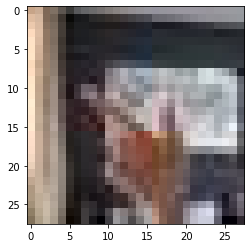

In [202]:
plt.imshow(x_test_norm[idx], cmap=plt.cm.binary)
plt.show()

### 4.1.3. 결과 시각화

In [203]:
# fit()에서 리턴하는 history 객체로 accuracy, loss를 시각화하는 함수
def show_fit_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 13))

    axes[0, 0].plot(history.history['accuracy'])
    axes[0, 0].set_title('Accuracy')

    axes[0, 1].plot(history.history['loss'])
    axes[0, 1].set_title('Loss')

    axes[1, 0].plot(history.history['val_accuracy'])
    axes[1, 0].set_title('Validation Accuracy')

    axes[1, 1].plot(history.history['val_loss'])
    axes[1, 1].set_title('Validation Loss')
    
    plt.show()

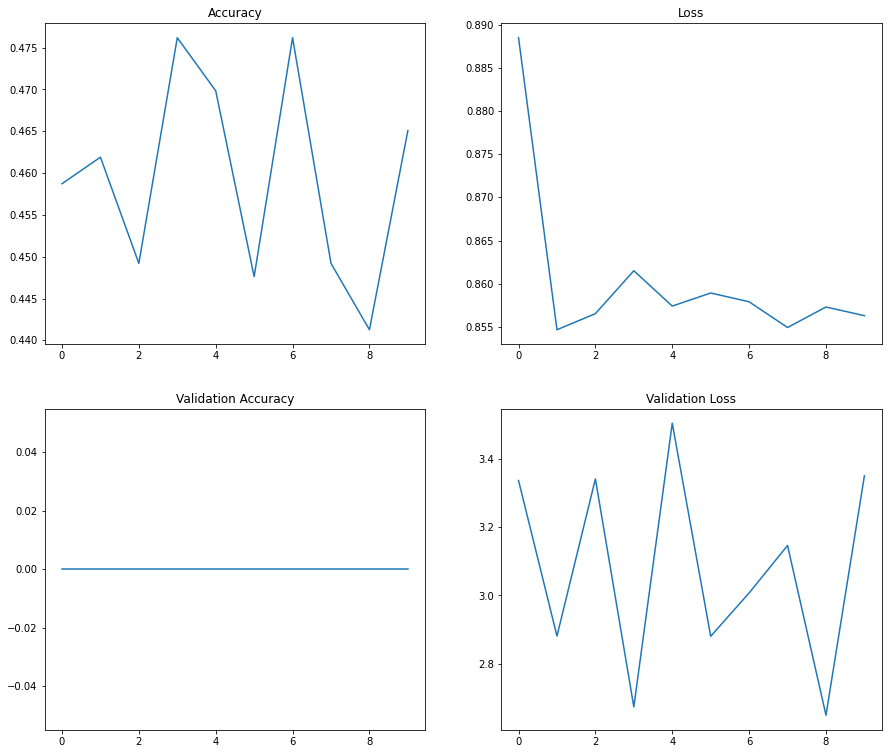

In [204]:
# accuracy, loss 시각화
show_fit_history(history)

## 4.2. 2차
- 학습 데이터 300개 추가

### 4.2.1. 추가 데이터 준비 및 학습

In [205]:
# 학습용 및 테스트용 이미지 사이즈 변경, 하위 폴더에 위치한 학습 데이터까지 사용
resize_train_test_images(recursive=True)

600  images to be resized.
600  images resized.
scissor 이미지 resize 완료!
600  images to be resized.
600  images resized.
rock 이미지 resize 완료!
600  images to be resized.
600  images resized.
paper 이미지 resize 완료!
100  images to be resized.
100  images resized.
test/scissor 이미지 resize 완료!
100  images to be resized.
100  images resized.
test/rock 이미지 resize 완료!
100  images to be resized.
100  images resized.
test/paper 이미지 resize 완료!


In [206]:
# 학습용 이미지 데이터 불러오기
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train) = load_data(image_dir_path, 1800, recursive=True)

# 테스트용 이미지 데이터 불러오기
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test) = load_data(image_dir_path, 300)

데이터의 이미지 개수는 1800 입니다.
데이터의 이미지 개수는 300 입니다.


In [207]:
# 정규화

# 학습용 데이터 
x_train_norm = x_train/255.0

# 테스트용 데이터
x_test_norm = x_test/255.0

In [208]:
# 학습

# 하이퍼파라미터
n_channel_1=32
n_channel_2=64
n_dense=64
n_train_epoch=10
validation_split=0.3

history = model.fit(x_train_norm, y_train, epochs=n_train_epoch, validation_split=validation_split)

Epoch 1/10
40/40 [==============================] - 1s 23ms/step - loss: 0.8569 - accuracy: 0.4738 - val_loss: 3.1301 - val_accuracy: 0.0000e+00
Epoch 2/10
40/40 [==============================] - 1s 22ms/step - loss: 0.8497 - accuracy: 0.4429 - val_loss: 2.9553 - val_accuracy: 0.0000e+00
Epoch 3/10
40/40 [==============================] - 1s 22ms/step - loss: 0.8493 - accuracy: 0.4802 - val_loss: 2.6514 - val_accuracy: 0.0000e+00
Epoch 4/10
40/40 [==============================] - 1s 22ms/step - loss: 0.8414 - accuracy: 0.4952 - val_loss: 2.7835 - val_accuracy: 0.0000e+00
Epoch 5/10
40/40 [==============================] - 1s 23ms/step - loss: 0.8398 - accuracy: 0.4794 - val_loss: 3.1938 - val_accuracy: 0.0000e+00
Epoch 6/10
40/40 [==============================] - 1s 22ms/step - loss: 0.8337 - accuracy: 0.4683 - val_loss: 3.4321 - val_accuracy: 0.0000e+00
Epoch 7/10
40/40 [==============================] - 1s 22ms/step - loss: 0.8321 - accuracy: 0.4881 - val_loss: 4.2230 - val_accura

### 4.2.2. 결과

In [209]:
# 평가
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 2.1684 - accuracy: 0.3333
test_loss: 2.1683549880981445 
test_accuracy: 0.3333333432674408


### 4.2.3. 결과 시각화

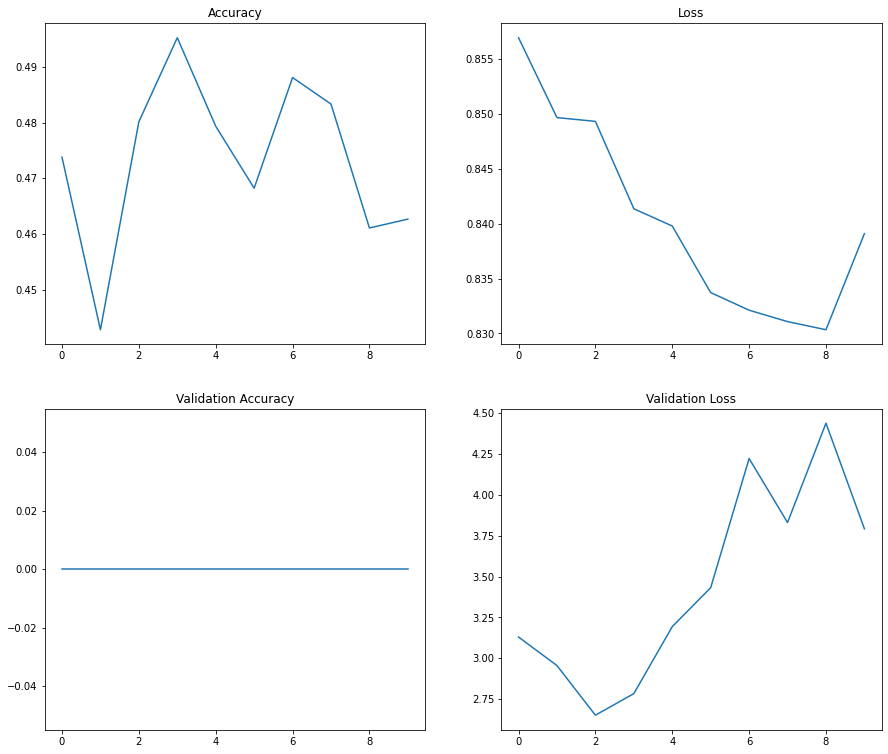

In [210]:
# accuracy, loss 시각화
show_fit_history(history)

## 4.3. 3차
- train-val 나눌 때 stratify 적용

In [211]:
x_train_norm, x_val_norm, y_train, y_val = train_test_split(x_train_norm, y_train, random_state=0,
                                                            stratify=y_train)

In [212]:
# 하이퍼파라미터
n_channel_1=32
n_channel_2=64
n_dense=64
n_train_epoch=10

history = model.fit(x_train_norm, y_train, epochs=n_train_epoch, validation_data=(x_val_norm, y_val))

Epoch 1/10
43/43 [==============================] - 1s 21ms/step - loss: 1.1459 - accuracy: 0.3333 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 2/10
43/43 [==============================] - 1s 21ms/step - loss: 1.0988 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 3/10
43/43 [==============================] - 1s 21ms/step - loss: 1.0988 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 4/10
43/43 [==============================] - 1s 21ms/step - loss: 1.0988 - accuracy: 0.3200 - val_loss: 1.0986 - val_accuracy: 0.3289
Epoch 5/10
43/43 [==============================] - 1s 21ms/step - loss: 1.0987 - accuracy: 0.3348 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 6/10
43/43 [==============================] - 1s 21ms/step - loss: 1.0987 - accuracy: 0.3170 - val_loss: 1.0987 - val_accuracy: 0.3067
Epoch 7/10
43/43 [==============================] - 1s 20ms/step - loss: 1.0987 - accuracy: 0.3348 - val_loss: 1.0987 - val_accuracy: 0.3089
Epoch 8/10
43

### 4.3.2. 결과

In [213]:
# 평가
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 1.0987 - accuracy: 0.3333
test_loss: 1.0986557006835938 
test_accuracy: 0.3333333432674408


### 4.3.3. 결과 시각화

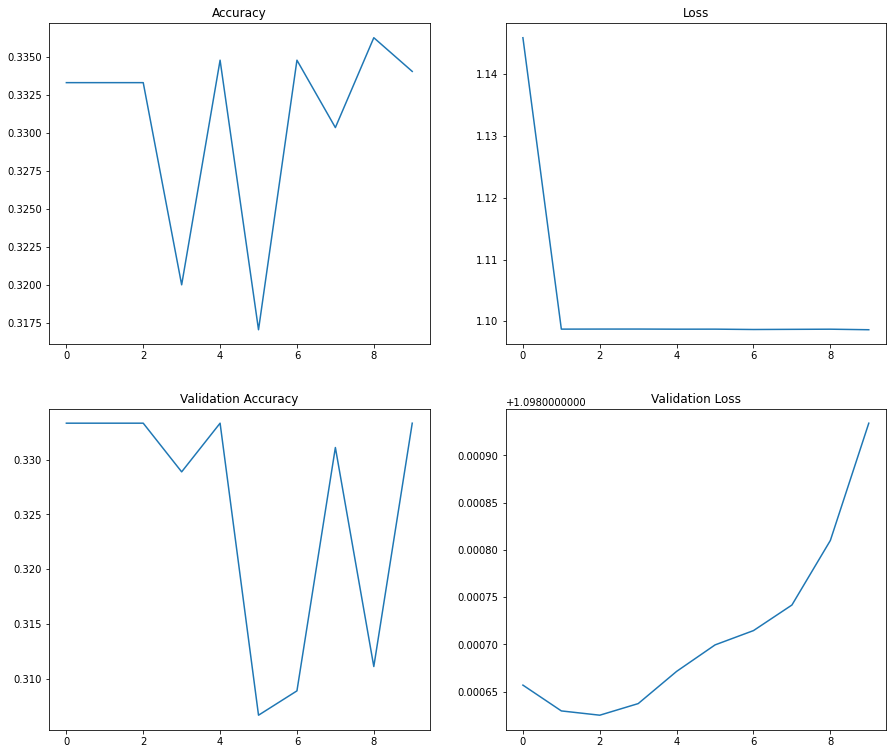

In [214]:
# accuracy, loss 시각화
show_fit_history(history)

## 4.4. 4차
- BatchNormalization 적용

In [215]:
# 하이퍼파라미터
n_channel_1=32
n_channel_2=64
n_dense=64
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train_norm, y_train, epochs=n_train_epoch, validation_data=(x_val_norm, y_val))

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 1600)            

### 4.4.2. 결과

In [216]:
# 평가
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 1.1012 - accuracy: 0.3333
test_loss: 1.1012178659439087 
test_accuracy: 0.3333333432674408


### 4.4.3. 결과 시각화

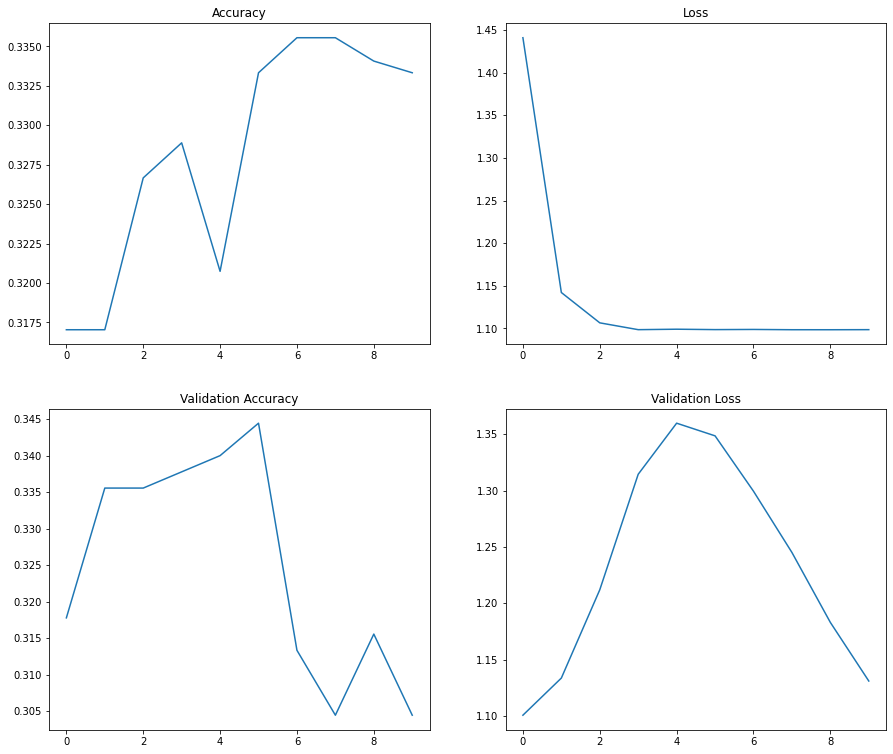

In [217]:
# accuracy, loss 시각화
show_fit_history(history)